In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import copy
from itertools import permutations, combinations

from scipy.stats import pearsonr, spearmanr

import torch
import torch.nn as nn
import torch.nn.functional as F

import logomaker

from NegativeClassOptimization import ml, visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing, datasets

# Functions from 07e* notebooks
import utils_07

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
def task_generator_experimental():

    task_types = (
        datasets.ClassificationTaskType.HIGH_VS_95LOW,
        datasets.ClassificationTaskType.HIGH_VS_LOOSER,
    )

    # Generate: high vs 95low, high vs looser
    seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
    for ag_1 in ["HR2P"]:
        for seed_id, split_id in seed_split_ids:
            for task_type in task_types:
                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )
                yield task

# Example computation for 1 task

In [7]:
tasks

[HIGH_VS_95LOW__HR2P__auto__0__42,
 HIGH_VS_LOOSER__HR2P__auto__0__42,
 HIGH_VS_95LOW__HR2P__auto__1__42,
 HIGH_VS_LOOSER__HR2P__auto__1__42,
 HIGH_VS_95LOW__HR2P__auto__2__42,
 HIGH_VS_LOOSER__HR2P__auto__2__42,
 HIGH_VS_95LOW__HR2P__auto__3__42,
 HIGH_VS_LOOSER__HR2P__auto__3__42,
 HIGH_VS_95LOW__HR2P__auto__0__0,
 HIGH_VS_LOOSER__HR2P__auto__0__0,
 HIGH_VS_95LOW__HR2P__auto__0__1,
 HIGH_VS_LOOSER__HR2P__auto__0__1,
 HIGH_VS_95LOW__HR2P__auto__0__2,
 HIGH_VS_LOOSER__HR2P__auto__0__2,
 HIGH_VS_95LOW__HR2P__auto__0__3,
 HIGH_VS_LOOSER__HR2P__auto__0__3,
 HIGH_VS_95LOW__HR2P__auto__0__4,
 HIGH_VS_LOOSER__HR2P__auto__0__4]

In [11]:
import copy

tasks = list(task_generator_experimental())

# Workflow per task from here on.
task = tasks[0]
print(task)
utils_07.loader.load(task, attributions_toload="v2.0-2", load_zscores=True)

weights = (
    task.state_dict["module.linear_2.weight"].numpy().tolist()
)
bias: float = float(
    task.state_dict["module.linear_2.bias"].numpy()[0]
)

print(weights, bias)

HIGH_VS_95LOW__HR2P__auto__0__42
[[0.006882637273520231, 0.0550973080098629, 1.3690130710601807, -1.8610104322433472, 1.3528577089309692, -1.7798056602478027, -1.5287450551986694, -1.6389880180358887, 1.2908458709716797, -1.7366371154785156]] -0.2806556820869446


In [12]:
# Get the z-scores
df = pd.DataFrame.from_records(task.z_records)

# Decompose z-scores into 10 columns
df = df.join(pd.DataFrame(df.z.str[0].tolist(), index=df.index))

# Drop col z and rename cols to neuron_0, neuron_1, ...
df = df.drop(columns=["z"]).rename(
    columns={i: f"neuron_{i}" for i in range(10)}
)

# Transform z-scores to activations with Relu for all neuron_i cols
df.set_index("slide", inplace=True)
df = df.applymap(lambda x: max(0, x))

df.head()

,neuron_0,neuron_1,neuron_2,neuron_3,neuron_4,neuron_5,neuron_6,neuron_7,neuron_8,neuron_9
slide,,,,,,,,,,
CDRAYCDTPTCAKWPEYFQPW,0,0,0.000000,2.452626,0.000000,2.477979,2.936243,2.443839,0.000000,2.163935
CDVAYCSISRCLTWWEYFQHW,0,0,0.221352,1.910125,0.098362,2.097499,2.326940,1.911409,0.139736,1.597169
CDVGQCDSSNCAKWHEYFQHW,0,0,0.578015,1.439620,0.540925,1.490333,1.628407,1.368038,0.553995,1.317956
FDVAYCHTPTCAKWPEYFQWW,0,0,0.086663,1.840056,0.084630,2.131100,2.401941,1.940378,0.091630,1.816218
FDVGQCDSSNCAKWPDYFQNW,0,0,0.204123,1.663057,0.205964,1.726172,1.867887,1.479387,0.235822,1.712212


In [13]:
# Get the logits and the others from attributions
df_attr = pd.DataFrame.from_records(task.attributions)
df = pd.merge(
    left=df,
    right=df_attr,
    left_index=True,
    right_on="slide",
)
df.sort_values(by="logits", ascending=False, inplace=True)
df.head()

,neuron_0,neuron_1,neuron_2,neuron_3,neuron_4,neuron_5,neuron_6,neuron_7,neuron_8,neuron_9,slide,logits,expits,y_pred,y_true,is_pred_correct,DeepLIFT_LOCAL_v2.0-2,DeepLIFT_GLOBAL_R10_v2.0-2,exec_time
0,0,0,2.512147,0.0,2.659877,0.0,0.0,0.0,2.771011,0.0,HDVGYCDTPTCASWPEYFQHW,10.333889,0.999967,1,1,True,"[[0.0, 0.4818393290042877, -0.0003556657466106...","[[0.058154381811618805, -4.791101932525635, 0....",193.47013
1,0,0,2.569848,0.0,2.655116,0.0,0.0,0.0,2.670635,0.0,HDTGYCDSSRCLTWPEYFQHW,10.276872,0.999966,1,1,True,"[[0.0, 0.47434741258621216, 0.0, -0.0041377143...","[[0.05848030373454094, -4.7775797843933105, 0....",193.47013
2,0,0,2.485193,0.0,2.459984,0.0,0.0,0.0,2.539601,0.0,HDVGYCDSSRCLTWPEYFQHW,9.727847,0.999940,1,1,True,"[[0.0, 0.4869002401828766, -0.0006009440985508...","[[0.06047400087118149, -4.889072895050049, 0.0...",193.47013
3,0,0,2.369918,0.0,2.469682,0.0,0.0,0.0,2.481673,0.0,HDVGYCTSSRCLTWPEYFVHW,9.508378,0.999926,1,1,True,"[[0.0, 0.4857386648654938, -0.0009141292539425...","[[0.06017644330859184, -4.898996353149414, 0.0...",193.47013
4,0,0,2.395241,0.0,2.459228,0.0,0.0,0.0,2.461776,0.0,HDVGFCESSRCLTWPEYFQHW,9.503219,0.999925,1,1,True,"[[0.0, 0.48196345567703247, 0.0, -0.0045895748...","[[0.05987776443362236, -4.843071937561035, 0.0...",193.47013


Text(0.5, 0, 'Slide ~ logit')

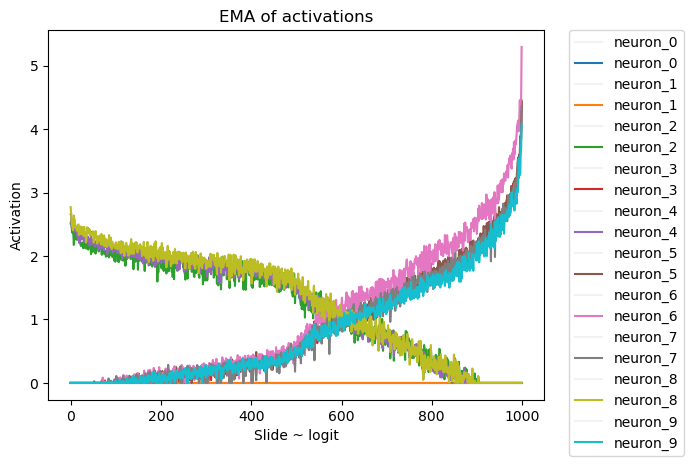

In [18]:
for i in range(10):

    # Compute EMA
    # Plot column without label in legend
    df[f"neuron_{i}"].plot(alpha=0.1, label=None, color="gray")
    ema = df[f"neuron_{i}"].ewm(span=1).mean()
    ema.plot()

# Place legend out of grid
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title("EMA of activations")
plt.ylabel("Activation")
plt.xlabel("Slide ~ logit")

HIGH_VS_LOOSER__HR2P__auto__0__42


Text(0.5, 0, 'Slide ~ logit')

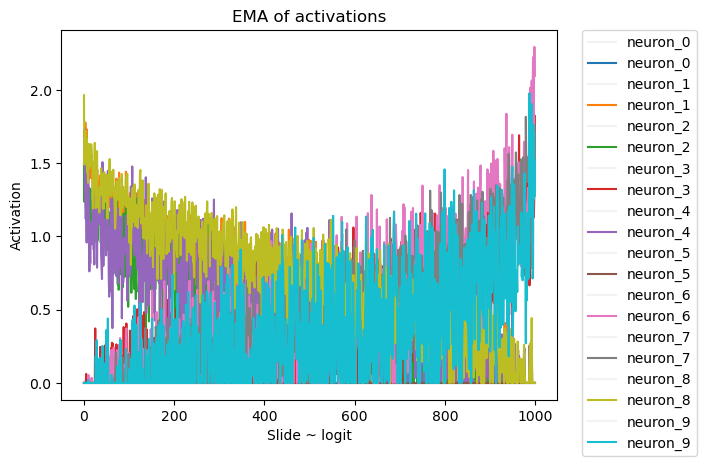

In [41]:
import copy

# Workflow per task from here on.
task = tasks[1]
print(task)
utils_07.loader.load(task, attributions_toload="v2.0-2", load_zscores=True)

weights = (
    task.state_dict["module.linear_2.weight"].numpy().tolist()
)
bias: float = float(
    task.state_dict["module.linear_2.bias"].numpy()[0]
)


# Get the z-scores
df = pd.DataFrame.from_records(task.z_records)

# Decompose z-scores into 10 columns
df = df.join(pd.DataFrame(df.z.str[0].tolist(), index=df.index))

# Drop col z and rename cols to neuron_0, neuron_1, ...
df = df.drop(columns=["z"]).rename(
    columns={i: f"neuron_{i}" for i in range(10)}
)

# Transform z-scores to activations with Relu for all neuron_i cols
df.set_index("slide", inplace=True)
df = df.applymap(lambda x: max(0, x))


# Get the logits and the others from attributions
df_attr = pd.DataFrame.from_records(task.attributions)
df = pd.merge(
    left=df,
    right=df_attr,
    left_index=True,
    right_on="slide",
)
df.sort_values(by="logits", ascending=False, inplace=True)


for i in range(10):

    # Compute EMA
    # Plot column without label in legend
    df[f"neuron_{i}"].plot(alpha=0.1, label=None, color="gray")
    ema = df[f"neuron_{i}"].ewm(span=1).mean()
    ema.plot()

# Place legend out of grid
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title("EMA of activations")
plt.ylabel("Activation")
plt.xlabel("Slide ~ logit")

# Explore stats across datasets

Consider to explore
- basic stats regarding the w2: #pos, #neg, max neg, skewness over neg/pos
- plot some of them, esp interesting ones. 1v9 vs 1v1 is esp. interesting, but also vs Looser vs vs Non-binder

In [29]:
from scipy.stats import skew


path = Path("07g_Activations_stats_experimental.csv")


if path.exists():
    df = pd.read_csv(path, index_col=0)
else:

    tasks = list(task_generator_experimental())

    records = []
    for task in tasks:
        
        print(f"Loading task {task}")
        try:
            utils_07.loader.load(task, attributions_toload="v2.0-2", load_zscores=True)
        except:
            print(f"Failed to load task {task}")
            continue

        weights = np.array((
            task.state_dict["module.linear_2.weight"].numpy().tolist()
        )[0])
        bias: float = float(
            task.state_dict["module.linear_2.bias"].numpy()[0]
        )

        # Get the z-scores
        df = pd.DataFrame.from_records(task.z_records)

        # Decompose z-scores into 10 columns
        df = df.join(pd.DataFrame(df.z.str[0].tolist(), index=df.index))

        # Drop col z and rename cols to neuron_0, neuron_1, ...
        df = df.drop(columns=["z"]).rename(
            columns={i: f"neuron_{i}" for i in range(10)}
        )

        # Transform z-scores to activations with Relu for all neuron_i cols
        df.set_index("slide", inplace=True)
        df = df.applymap(lambda x: max(0, x))

        # Add data from attributions
        df_attr = pd.DataFrame.from_records(task.attributions)
        df = pd.merge(
            left=df,
            right=df_attr,
            left_index=True,
            right_on="slide",
        )
        df.sort_values(by="logits", ascending=False, inplace=True)
        
        records.append({
            "task": task,
            "w_#pos": (weights > 0).sum(),
            "w_#neg": (weights < 0).sum(),
            "w_avg_pos": weights[weights > 0].mean(),
            "w_avg_neg": weights[weights < 0].mean(),
            "w_skewness_pos": skew(weights[weights > 0]),
            "w_skewness_neg": skew(weights[weights < 0]),
        })

    df = pd.DataFrame.from_records(records)
    df.to_csv(path)

df.head()

Loading task HIGH_VS_95LOW__HR2P__auto__0__42
Loading task HIGH_VS_LOOSER__HR2P__auto__0__42
Loading task HIGH_VS_95LOW__HR2P__auto__1__42
Failed to load task HIGH_VS_95LOW__HR2P__auto__1__42
Loading task HIGH_VS_LOOSER__HR2P__auto__1__42
Failed to load task HIGH_VS_LOOSER__HR2P__auto__1__42
Loading task HIGH_VS_95LOW__HR2P__auto__2__42
Failed to load task HIGH_VS_95LOW__HR2P__auto__2__42
Loading task HIGH_VS_LOOSER__HR2P__auto__2__42
Failed to load task HIGH_VS_LOOSER__HR2P__auto__2__42
Loading task HIGH_VS_95LOW__HR2P__auto__3__42
Failed to load task HIGH_VS_95LOW__HR2P__auto__3__42
Loading task HIGH_VS_LOOSER__HR2P__auto__3__42
Failed to load task HIGH_VS_LOOSER__HR2P__auto__3__42
Loading task HIGH_VS_95LOW__HR2P__auto__0__0
Failed to load task HIGH_VS_95LOW__HR2P__auto__0__0
Loading task HIGH_VS_LOOSER__HR2P__auto__0__0
Failed to load task HIGH_VS_LOOSER__HR2P__auto__0__0
Loading task HIGH_VS_95LOW__HR2P__auto__0__1
Failed to load task HIGH_VS_95LOW__HR2P__auto__0__1
Loading task H

,task,w_#pos,w_#neg,w_avg_pos,w_avg_neg,w_skewness_pos,w_skewness_neg
0,HIGH_VS_95LOW__HR2P__auto__0__42,5,5,0.814939,-1.709037,-0.404957,0.303872
1,HIGH_VS_LOOSER__HR2P__auto__0__42,5,5,1.150108,-1.431392,-1.225582,1.326812


In [30]:
task_types = []
ag_pos = []
for task in df["task"].values:
    
    if type(task) == str:
        task = datasets.ClassificationTask.init_from_str(task)
    
    task_types.append(task.task_type.to_str())
    ag_pos.append(task.ag_pos)

df["task_type"] = task_types
df["ag_pos"] = ag_pos
df.head()

,task,w_#pos,w_#neg,w_avg_pos,w_avg_neg,w_skewness_pos,w_skewness_neg,task_type,ag_pos
0,HIGH_VS_95LOW__HR2P__auto__0__42,5,5,0.814939,-1.709037,-0.404957,0.303872,high_vs_95low,HR2P
1,HIGH_VS_LOOSER__HR2P__auto__0__42,5,5,1.150108,-1.431392,-1.225582,1.326812,high_vs_looser,HR2P


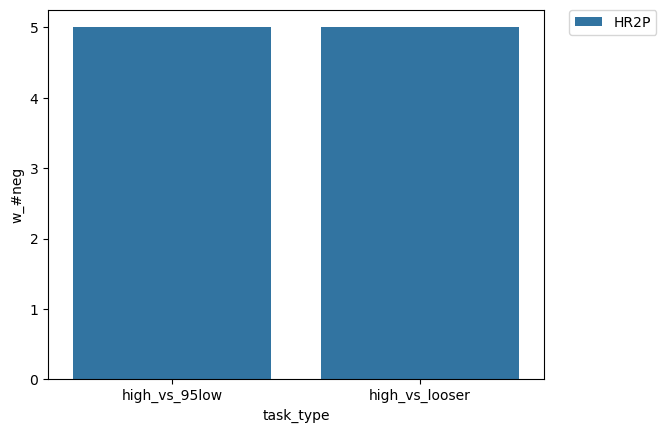

In [31]:
sns.barplot(
    data=df,
    x="task_type",
    y="w_#neg",
    hue="ag_pos",
)

# Legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

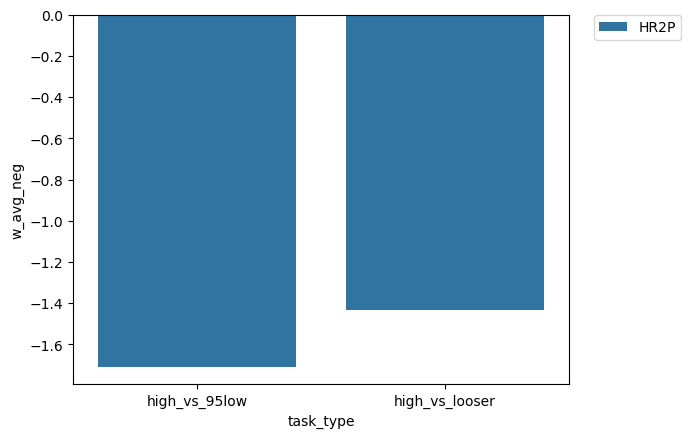

In [32]:
sns.barplot(
    data=df,
    x="task_type",
    y="w_avg_neg",
    hue="ag_pos",
)

# Legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

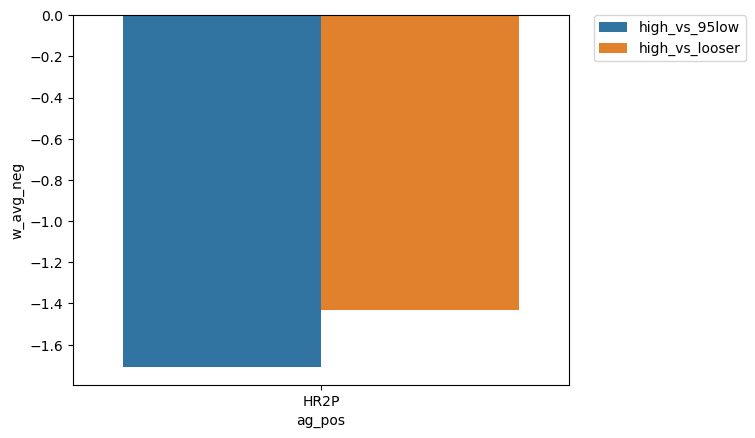

In [33]:
sns.barplot(
    data=df,
    x="ag_pos",
    y="w_avg_neg",
    hue="task_type",
)

# Legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

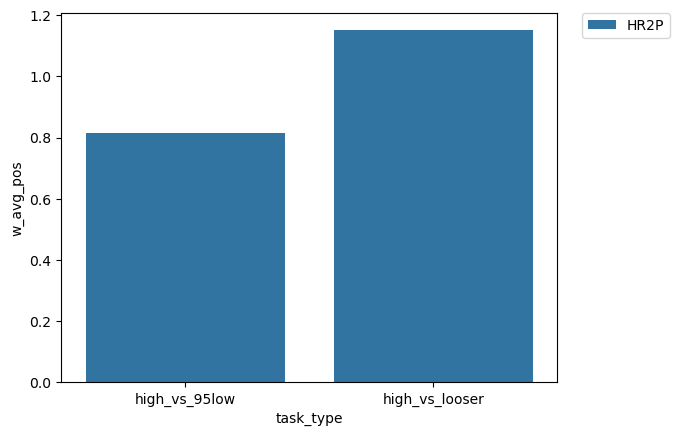

In [34]:
sns.barplot(
    data=df,
    x="task_type",
    y="w_avg_pos",
    hue="ag_pos",
)

# Legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

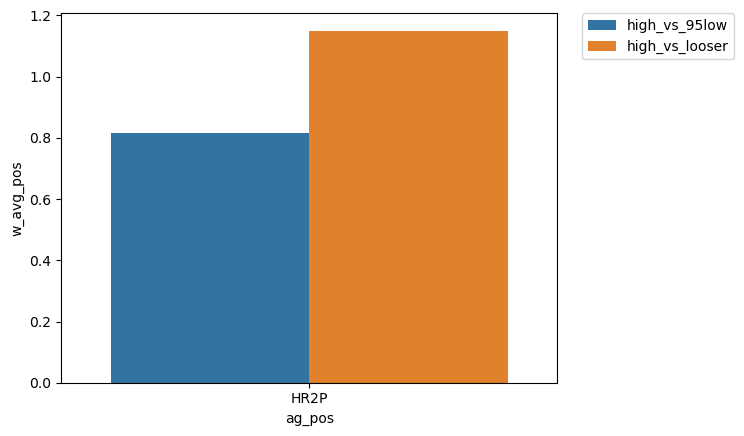

In [35]:
sns.barplot(
    data=df,
    x="ag_pos",
    y="w_avg_pos",
    hue="task_type",
)

# Legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

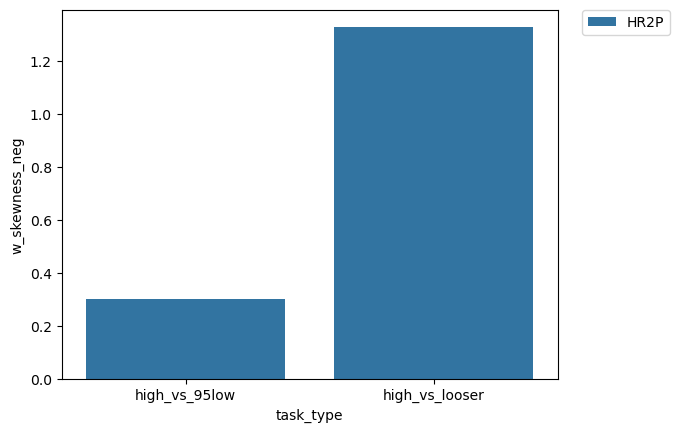

In [36]:
sns.barplot(
    data=df,
    x="task_type",
    y="w_skewness_neg",
    hue="ag_pos",
)

# Legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [37]:
df.query("ag_pos == '2YPV'")

,task,w_#pos,w_#neg,w_avg_pos,w_avg_neg,w_skewness_pos,w_skewness_neg,task_type,ag_pos


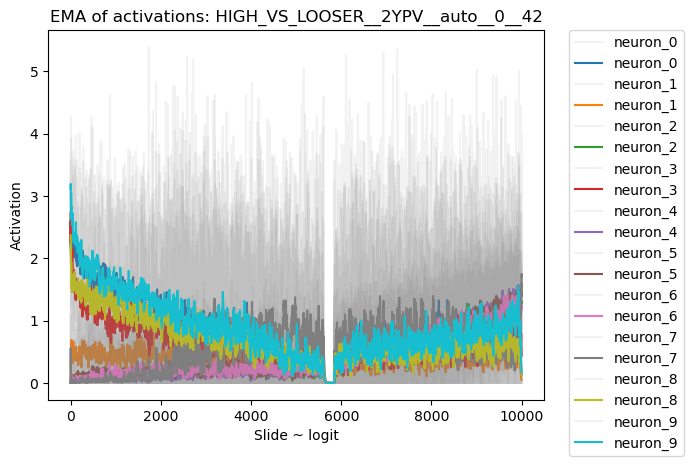

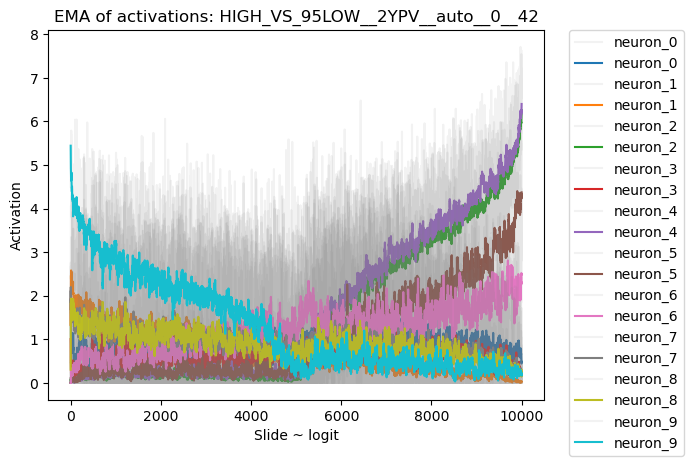

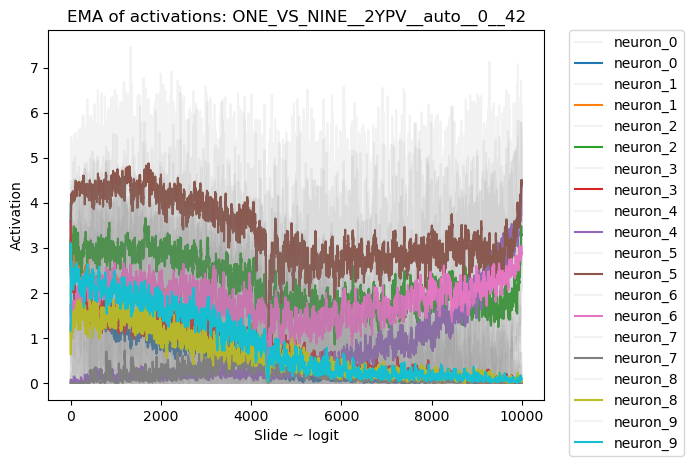

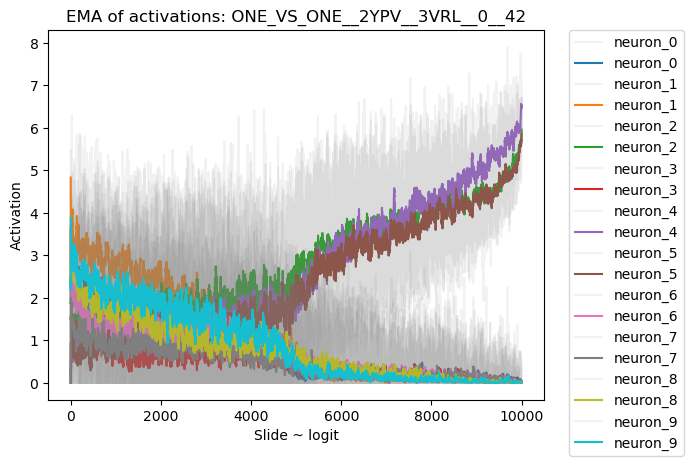

In [38]:
task_strs = [
    "HIGH_VS_LOOSER__2YPV__auto__0__42",
    "HIGH_VS_95LOW__2YPV__auto__0__42",
    "ONE_VS_NINE__2YPV__auto__0__42",
    "ONE_VS_ONE__2YPV__3VRL__0__42",
]

for task_str in task_strs:
    task = datasets.ClassificationTask.init_from_str(task_str)
    utils_07.loader.load(task, attributions_toload="v2.0-2", load_zscores=True)
    
    # Get the z-scores
    df_i = pd.DataFrame.from_records(task.z_records)

    # Decompose z-scores into 10 columns
    df_i = df_i.join(pd.DataFrame(df_i.z.str[0].tolist(), index=df_i.index))

    # Drop col z and rename cols to neuron_0, neuron_1, ...
    df_i = df_i.drop(columns=["z"]).rename(
        columns={i: f"neuron_{i}" for i in range(10)}
    )

    # Transform z-scores to activations with Relu for all neuron_i cols
    df_i.set_index("slide", inplace=True)
    df_i = df_i.applymap(lambda x: max(0, x))

    # Get the logits and the others from attributions
    df_attr = pd.DataFrame.from_records(task.attributions)
    df_i = pd.merge(
        left=df_i,
        right=df_attr,
        left_index=True,
        right_on="slide",
    )
    df_i.sort_values(by="logits", ascending=False, inplace=True)

    for i in range(10):

        # Compute EMA
        # Plot column without label in legend
        df_i[f"neuron_{i}"].plot(alpha=0.1, label=None, color="gray")
        ema = df_i[f"neuron_{i}"].ewm(span=30).mean()
        ema.plot()

        # Place legend out of grid
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        plt.title(f"EMA of activations: {task_str}")
        plt.ylabel("Activation")
        plt.xlabel("Slide ~ logit")
    plt.show()

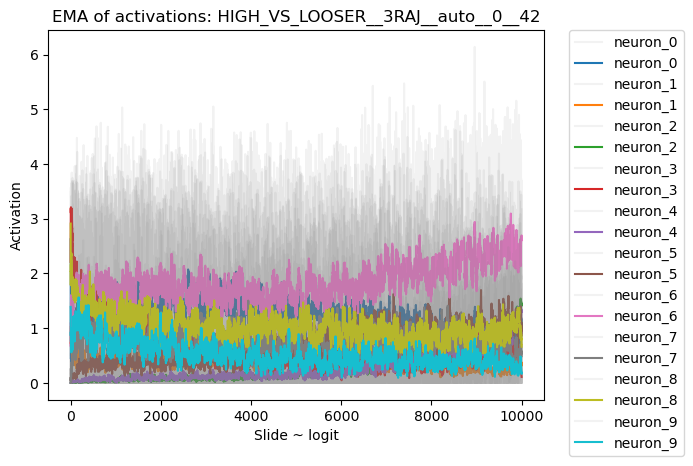

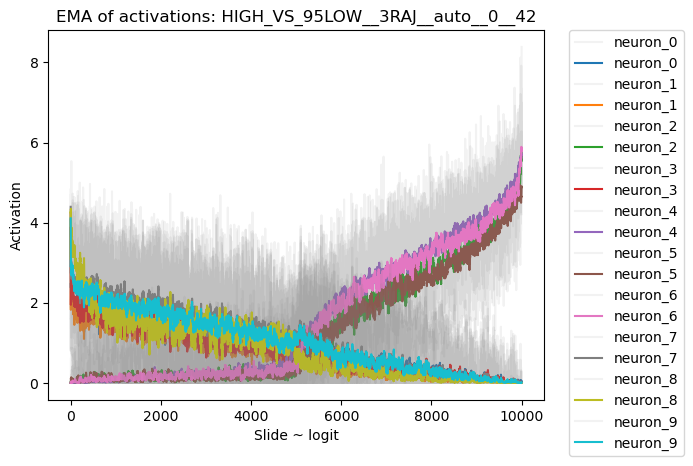

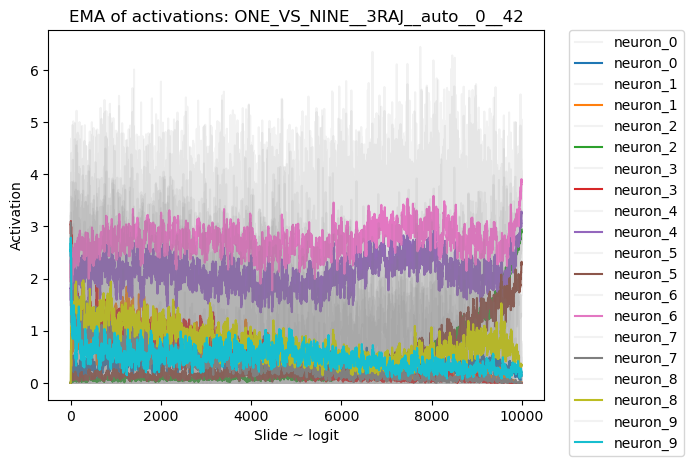

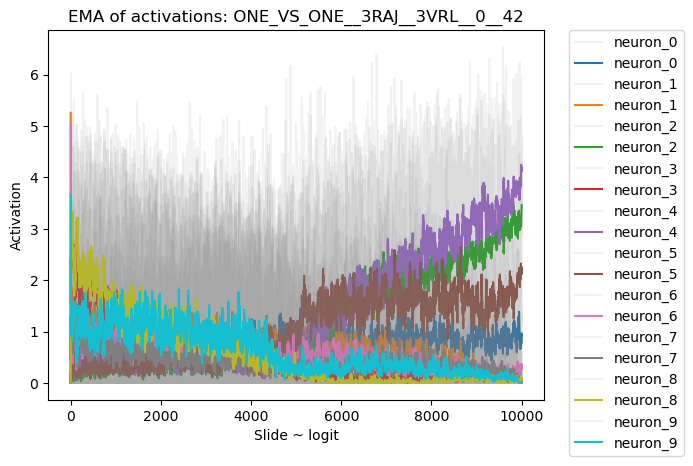

In [39]:
task_strs = [
    "HIGH_VS_LOOSER__3RAJ__auto__0__42",
    "HIGH_VS_95LOW__3RAJ__auto__0__42",
    "ONE_VS_NINE__3RAJ__auto__0__42",
    "ONE_VS_ONE__3RAJ__3VRL__0__42",
]

for task_str in task_strs:
    task = datasets.ClassificationTask.init_from_str(task_str)
    utils_07.loader.load(task, attributions_toload="v2.0-2", load_zscores=True)
    
    # Get the z-scores
    df_i = pd.DataFrame.from_records(task.z_records)

    # Decompose z-scores into 10 columns
    df_i = df_i.join(pd.DataFrame(df_i.z.str[0].tolist(), index=df_i.index))

    # Drop col z and rename cols to neuron_0, neuron_1, ...
    df_i = df_i.drop(columns=["z"]).rename(
        columns={i: f"neuron_{i}" for i in range(10)}
    )

    # Transform z-scores to activations with Relu for all neuron_i cols
    df_i.set_index("slide", inplace=True)
    df_i = df_i.applymap(lambda x: max(0, x))

    # Get the logits and the others from attributions
    df_attr = pd.DataFrame.from_records(task.attributions)
    df_i = pd.merge(
        left=df_i,
        right=df_attr,
        left_index=True,
        right_on="slide",
    )
    df_i.sort_values(by="logits", ascending=False, inplace=True)

    for i in range(10):

        # Compute EMA
        # Plot column without label in legend
        df_i[f"neuron_{i}"].plot(alpha=0.1, label=None, color="gray")
        ema = df_i[f"neuron_{i}"].ewm(span=30).mean()
        ema.plot()

        # Place legend out of grid
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        plt.title(f"EMA of activations: {task_str}")
        plt.ylabel("Activation")
        plt.xlabel("Slide ~ logit")
    plt.show()